## Model Build (part 1)

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
import csv
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [105]:
model_data = pd.read_csv('model_data.csv')

In [106]:
model_data.columns

Index(['id', 'name', 'close_date', 'stage', 'address', 'lat', 'lng',
       'ts_response', 'mobility_score', 'carshare', 'bikeshare', 'ridehailing',
       'masstransit', 'lat_lng', 'closest_ts', 'within_one_tenth',
       'within_one_half', 'within_one', 'within_five'],
      dtype='object')

## Feature Engineering

In [107]:
#feature engineering
#engineer a number out of stage
model_data.stage.value_counts()

Lost                 926
Closed Won           295
Deal Signed           97
Contract Sent         75
Presentation          65
Invoice Sent          64
Proposal Sent         62
Qualified Lead        60
Research/Donation     27
Contract Expired       8
Contract Review        3
Pilot                  1
Name: stage, dtype: int64

In [ ]:
#Closed Won, Deal Signed, Invoice Sent = 1; otherwise 0

In [108]:
def translate_stage(stage):
    if stage in ['Closed Won', 'Deal Signed', 'Invoice Sent']:
        return(1)
    else:
        return (0)

In [109]:
model_data['y'] = model_data['stage'].apply(translate_stage)

In [195]:
#feature engineering
y = model_data['y']
X = model_data[['lat',
                'lng',
                'mobility_score',
                'carshare',
                'bikeshare',
                'ridehailing',
                'masstransit',
                'closest_ts',
                'within_one_tenth',
                'within_one_half',
                'within_one',
                #'within_five'  #this was taken out because it caused scores to decrease
                ]]

## Split Data

In [ ]:
#may need to delete outliers here, or put a max on closest_ts

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=14)

In [197]:
#calculate baseline
print (y.value_counts())
print (1 - (456 / (1227+456)))

0    1227
1     456
Name: y, dtype: int64
0.7290552584670231


## Run Models

In [235]:
#random forest  (for grid search code, see notebook 09)
model = RandomForestClassifier(n_estimators=500
                               ,max_depth=5
                               ,min_samples_split=2
                               ,min_samples_leaf=1
                               ,max_features=3) 
scores = cross_val_score(model, X_train, y_train, cv=3)
print(scores)
print(np.mean(scores))

[0.75318066 0.76844784 0.7755102 ]
0.7657129009364559


In [236]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Text(0,0.5,'Feature importance')

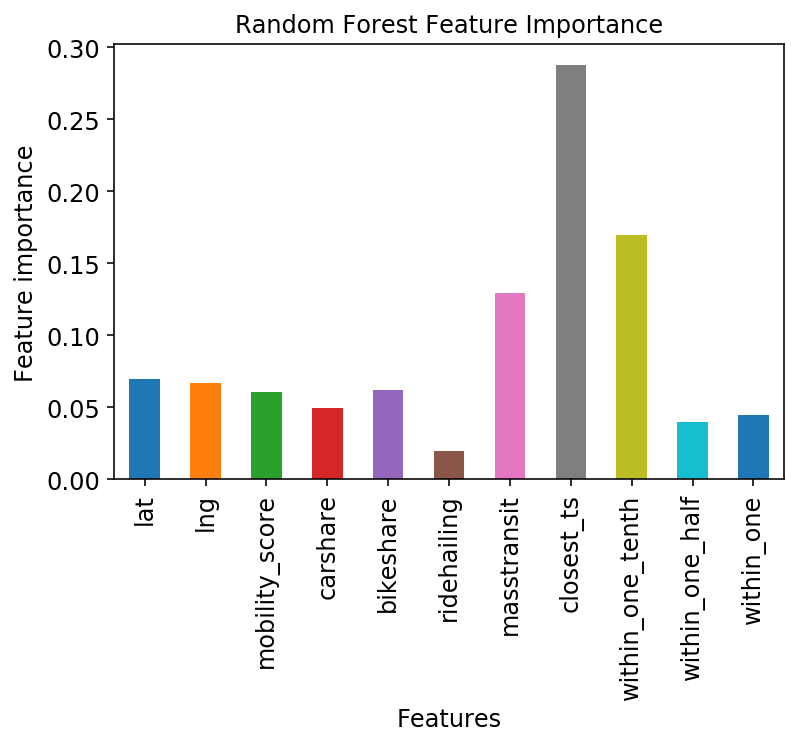

In [237]:
features = pd.DataFrame(list(zip(X.columns,model.feature_importances_))
                        ,columns=['feature','importance'])
features.plot(kind='bar', title='Random Forest Feature Importance', 
              x='feature', y='importance', fontsize='large', legend=False
              ,sort_columns=True)
plt.xticks(rotation = 90)
plt.xlabel('Features', fontsize='large')
plt.ylabel('Feature importance', fontsize='large')

In [238]:
#######GRADIENT BOOSTING model
model = GradientBoostingClassifier(max_features = 6, max_depth = 50) 
scores = cross_val_score(model, X_train, y_train, cv=3)
print(scores)
print(np.mean(scores))

[0.70737913 0.72773537 0.70408163]
0.713065378823285


In [239]:
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=50,
              max_features=6, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Text(0,0.5,'Feature importance')

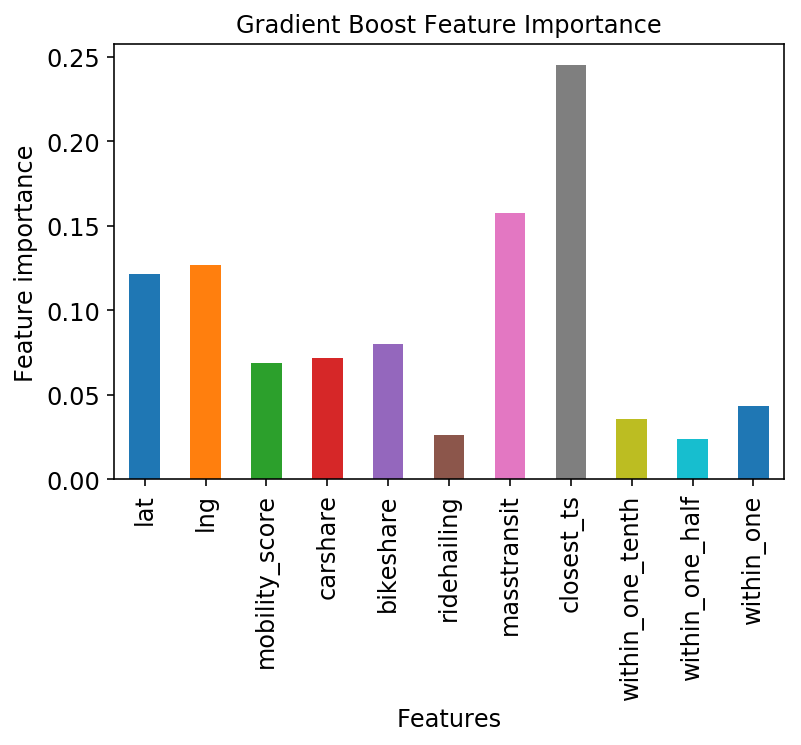

In [240]:
features = pd.DataFrame(list(zip(X.columns,model.feature_importances_))
                        ,columns=['feature','importance'])
features.plot(kind='bar', title='Gradient Boost Feature Importance', 
              x='feature', y='importance', fontsize='large', legend=False
              ,sort_columns=True)
plt.xticks(rotation = 90)
plt.xlabel('Features', fontsize='large')
plt.ylabel('Feature importance', fontsize='large')

In [241]:
####### ADABoost model
model = AdaBoostClassifier(n_estimators=100) 
scores = cross_val_score(model, X_train, y_train, cv=3)
print(scores)
print(np.mean(scores))

[0.73282443 0.74300254 0.75      ]
0.7419423240033928


In [242]:
model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

Text(0,0.5,'Feature importance')

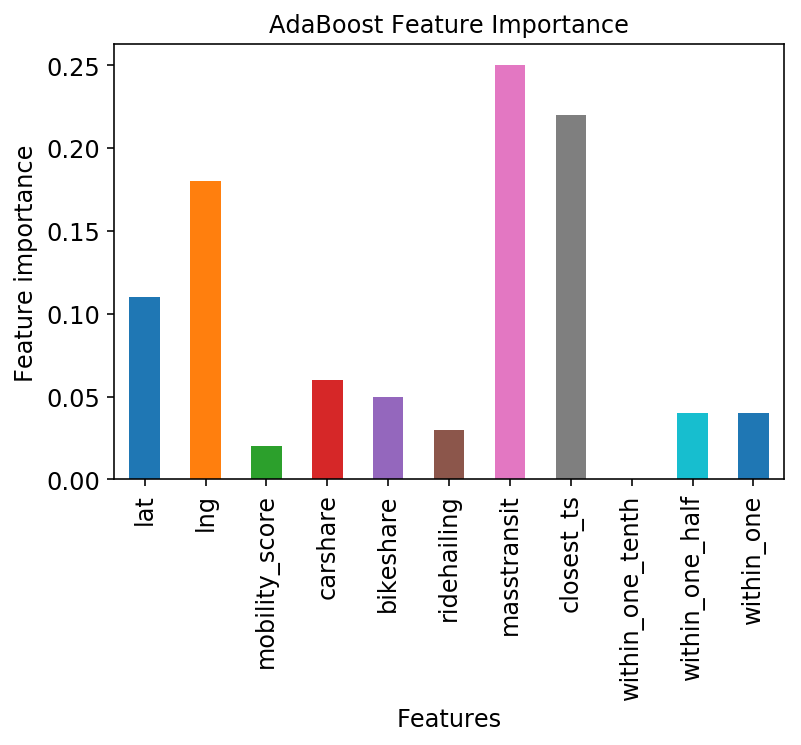

In [244]:
features = pd.DataFrame(list(zip(X.columns,model.feature_importances_))
                        ,columns=['feature','importance'])
features.plot(kind='bar', title='AdaBoost Feature Importance', 
              x='feature', y='importance', fontsize='large', legend=False
              ,sort_columns=True)
plt.xticks(rotation = 90)
plt.xlabel('Features', fontsize='large')
plt.ylabel('Feature importance', fontsize='large')

In [201]:
#Create keras Model
#X_train, X_test, y_train, y_test = train_test_split(Xtr, ytr, test_size=0.30, random_state=11)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)  #the scaler is fit only to the training data
X_test = ss.transform(X_test)

model = Sequential()

input_units = X_train.shape[1] #number of features in training set
hidden_units = input_units   #hidden layer has the same number of nodes as input

#first input layer
model.add(Dense(hidden_units            
                ,input_dim=input_units  
                ,activation='relu'
                #uncomment this to add L2 regularization
                #,kernel_regularizer=regularizers.l2(0.0001) 
               ))


#hidden layer (try with and without)
node_reduction = 0
model.add(Dense(hidden_units - node_reduction          
                ,input_dim=input_units  
                ,activation='tanh'
                #,kernel_regularizer=regularizers.l2(0.0001) 
               ))
#model.add(Dropout(0.8))

#final layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy'
              ,optimizer='adam'
               #added later 
              ,metrics=['binary_accuracy']
             )

(1178, 11) (1178,)
(505, 11) (505,)


In [202]:
#Run Keras model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
               epochs=60, batch_size=None, verbose=1)

Train on 1178 samples, validate on 505 samples
Epoch 1/60
1178/1178 [==============================] - 1s 799us/step - loss: 0.6671 - binary_accuracy: 0.6927 - val_loss: 0.6187 - val_binary_accuracy: 0.7505
Epoch 2/60
1178/1178 [==============================] - 0s 55us/step - loss: 0.6278 - binary_accuracy: 0.7173 - val_loss: 0.5969 - val_binary_accuracy: 0.7505
Epoch 3/60
1178/1178 [==============================] - 0s 56us/step - loss: 0.6030 - binary_accuracy: 0.7216 - val_loss: 0.5821 - val_binary_accuracy: 0.7545
Epoch 4/60
1178/1178 [==============================] - 0s 52us/step - loss: 0.5853 - binary_accuracy: 0.7258 - val_loss: 0.5712 - val_binary_accuracy: 0.7505
Epoch 5/60
1178/1178 [==============================] - 0s 58us/step - loss: 0.5716 - binary_accuracy: 0.7343 - val_loss: 0.5650 - val_binary_accuracy: 0.7564
Epoch 6/60
1178/1178 [==============================] - 0s 57us/step - loss: 0.5619 - binary_accuracy: 0.7394 - val_loss: 0.5593 - val_binary_accuracy: 0.760

Epoch 52/60
1178/1178 [==============================] - 0s 60us/step - loss: 0.5055 - binary_accuracy: 0.7767 - val_loss: 0.5381 - val_binary_accuracy: 0.7743
Epoch 53/60
1178/1178 [==============================] - 0s 57us/step - loss: 0.5050 - binary_accuracy: 0.7759 - val_loss: 0.5377 - val_binary_accuracy: 0.7743
Epoch 54/60
1178/1178 [==============================] - 0s 57us/step - loss: 0.5052 - binary_accuracy: 0.7759 - val_loss: 0.5383 - val_binary_accuracy: 0.7723
Epoch 55/60
1178/1178 [==============================] - 0s 56us/step - loss: 0.5045 - binary_accuracy: 0.7767 - val_loss: 0.5385 - val_binary_accuracy: 0.7723
Epoch 56/60
1178/1178 [==============================] - 0s 52us/step - loss: 0.5042 - binary_accuracy: 0.7801 - val_loss: 0.5385 - val_binary_accuracy: 0.7723
Epoch 57/60
1178/1178 [==============================] - 0s 55us/step - loss: 0.5042 - binary_accuracy: 0.7784 - val_loss: 0.5386 - val_binary_accuracy: 0.7723
Epoch 58/60
1178/1178 [=================

### Model Score Summary:
Random Forest:   crossval score 76.5%
Gradient Boost:  crossval score 71.6%
ADABoost:        crossval score 74.2%
Keras:           validation score 77.2%

More model buiding and grid searching in notebook 9


